This script implements the ACCV'18 paper "Continuous-time intensity estimation using event cameras"
Arxiv link: https://arxiv.org/pdf/1811.00386.pdf

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, sys
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
#from skimage.measure import compare_psnr
from skimage.io import imread
from skimage.io import imsave
import utils.visualization as vs
import utils.events_processing as ep
import math
import json

start time: 2.558515 
end time: 2.597280001
image shape: (2, 180, 240)
# of events: (14048,)


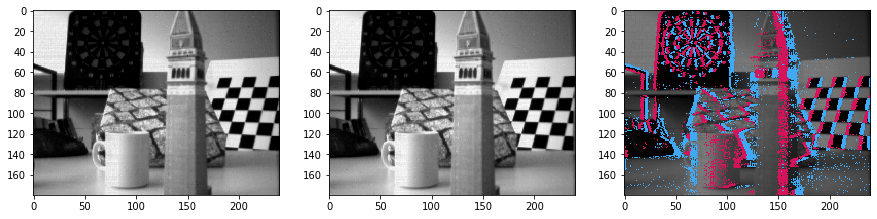

In [2]:
# load data (DAVIS)
vidName = 'slider_depth'
davisDir = os.path.join('F:\Winston\data\davis240', vidName)
imgDir = os.path.join(davisDir, 'images')
imgFileList = np.sort(os.listdir(imgDir))
imgPairId = [66, 67]
imgPair = np.array([imread(os.path.join(imgDir,imgFileList[imgPairId[0]]))/255.0, 
                    imread(os.path.join(imgDir,imgFileList[imgPairId[1]]))/255.0])
timeStart, timeEnd = ep.findTimeWindowFromId(os.path.join(davisDir, 'images.txt'), imgFileList, imgPairId)
print("start time:", timeStart, "\nend time:", timeEnd)
print("image shape:", np.shape(imgPair))
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(imgPair[0], cmap = 'gray')
plt.subplot(132)
plt.imshow(imgPair[1], cmap = 'gray')
eventsTime, eventsXYP = ep.loadEventsWithinTimeWindow(os.path.join(davisDir, 'events.txt'), timeStart, timeEnd)

#eventFrames = ep.binEventFrames(eventsTime, eventsXYP, method = 0, frameNum = 1)
img_ev = ep.overlayEventsOnImg(imgPair[0], eventsXYP)
plt.subplot(133)
plt.imshow(img_ev, cmap = 'gray')

In [3]:
class updateLogs():
    def __init__(self, logOfFrame, sigma_c):
        self.lmin = np.min(logOfFrame)
        self.lmax = np.max(logOfFrame)
        self.k = 0.05*(self.lmax - self.lmin)
        self.L1 = self.lmin + self.k
        self.L2 = self.lmax - self.k
        self.a1 = 2*math.pi
        self.a0 = self.a1
        self.log0 = logOfFrame
        self.sigma_c = sigma_c

    def updateAlpha(self, Lf):
        self.lambda0 = 0.1
        if Lf < self.L1 and Lf >= self.lmax:
            self.a0 = self.lambda0*self.a1 + (1 - self.lambda0)*self.a1*(Lf - self.lmin)/(self.L1 - self.lmin)
        elif Lf > self.L2 and Lf < self.lmax:
            self.a0 = self.lambda0*self.a1 + (1 - self.lambda0)*self.a1*(Lf - self.lmax)/(self.L2 - self.lmax)
        else:
            self.a0 = self.a1
        return self.a0
    

PSNR: 23.326086946658954
SSIM: 0.7708550842394633


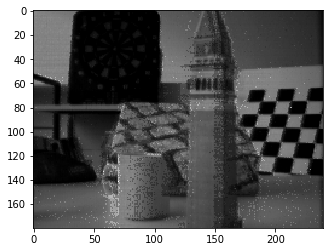

In [6]:
eps = 1e-10
sigma_c_list = np.linspace(0.0, 0.5, 10)
logOfFrame = np.log(imgPair[0]+eps)
max_psnr = 0
for s in sigma_c_list:
    logs = updateLogs(logOfFrame, s)
    for i in range(len(eventsTime)):
        dt = eventsTime[i] - timeStart
        ex = eventsXYP[i,0]
        ey = eventsXYP[i,1]
        ep = eventsXYP[i,2]
        logs.log0[ey, ex] = np.exp(-logs.a0*dt)*logs.log0[ey, ex] + (1 - np.exp(-logs.a0*dt))*logOfFrame[ey, ex]
        logs.log0[ey, ex] = logs.log0[ey, ex] + ep * logs.sigma_c
        logs.updateAlpha(logOfFrame[ey, ex])

    img_cf = np.exp(logs.log0) - eps
    cf_psnr = psnr(imgPair[1], img_cf)
    if cf_psnr > max_psnr:
        cf_best_psnr = img_cf
        max_psnr = cf_psnr
        best_c = s

plt.imshow(cf_best_psnr, cmap = 'gray')
cf_psnr = psnr(imgPair[1], cf_best_psnr)
cf_ssim = ssim(imgPair[1], cf_best_psnr)
print("PSNR:", cf_psnr)
print("SSIM:", cf_ssim)

In [7]:
resultsDir = os.path.join('results', 'compare-cf-mbr')
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
    
caseDir = os.path.join(resultsDir, vidName + '-predict-%03d-%03d' % (imgPairId[0], imgPairId[1]))
if not os.path.isdir(caseDir):
    os.mkdir(caseDir)
    
# save ground truth images
imsave(os.path.join(caseDir, 'gt-f1.png'), imgPair[0])
imsave(os.path.join(caseDir, 'gt-f2.png'), imgPair[1])
imsave(os.path.join(caseDir, 'f1-events.png'), img_ev)

# save reconstruction image
imsave(os.path.join(caseDir, 'cf-rec.png'), vs.imgBetween01(cf_best_psnr))

with open(os.path.join(caseDir, 'psnr_ssim.txt'), 'a') as f:
    f.write('CF-PSNR: %04f\n' % cf_psnr)
    f.write('CF-SSIM: %04f\n' % cf_ssim)
    f.write('CF-sigma_c %03f\n' % best_c)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [10]:
# define lres_gt
lres_gt = np.expand_dims(np.expand_dims(imgPair[0], 0), 3)
lres_dim = np.shape(lres_gt)
evf_gt = np.expand_dims(ep.binEventFrames(eventsTime, eventsXYP, method = 1), 3)
evf_dim = np.shape(evf_gt)
hres_dim = (np.size(evf_gt, 0) + 1, np.size(evf_gt, 1), np.size(evf_gt, 2), np.size(evf_gt, 3))


Binned evf shape: (11, 180, 240)


ev_weight: 7.0
tanh_coef: 9.0
TV_xy: 0.25
TV_t: 22.0
hres_init shape: (1, 12, 180, 240, 1)
----Finished generating lres_tensor, shape (1, 1, 180, 240, 1)
evf_tanh, shape: (1, 11, 180, 240, 1)


C:\Users\45289\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
C:\Users\45289\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Epoch: 0000 -- learning rate: 0.002000
Epoch: 0200 -- learning rate: 0.002000
Epoch: 0400 -- learning rate: 0.001000
Epoch: 0600 -- learning rate: 0.000500
Epoch: 0800 -- learning rate: 0.000250
Finished! results\compare-cf-mbr\slider_depth-predict-066-067
PSNR: 25.118556729965892


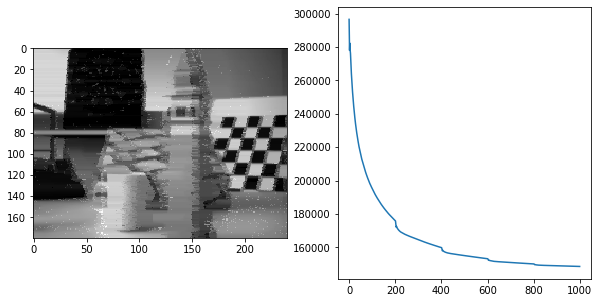

In [61]:
# models
def init_hres(config, lres_gt):
    # input lres_gt should be in shape (t, y, x, c)
    if config.syn_mode == 'i':
        lres_mean = np.expand_dims(np.mean(lres_gt, axis = 0), axis = 0)
        #print("shape of 'lres_mean'", np.shape(lres_mean))
        # (1, y, x, c)
        lres_start = tf.Variable(np.expand_dims(lres_gt[0], axis = 0), dtype = tf.float32)
        lres_end = tf.Variable(np.expand_dims(lres_gt[1], axis = 0), dtype = tf.float32)
        # init hres
        for i in range(config.unknown+2):
            a = i / (config.unknown + 1)
            if i == 0:
                hres_init = lres_start
            else:
                frame = (1-a)*lres_start + a*lres_end
                hres_init = tf.concat([hres_init, tf.Variable(frame, dtype = tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    elif config.syn_mode == 'p':
        for i in range(config.unknown+1):
            if i == 0:
                hres_init = tf.Variable(lres_gt, dtype= tf.float32)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_gt, dtype= tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    else:
        for i in range(config.unknown):
            if i == 0:
                hres_init = tf.Variable(lres_gt, dtype= tf.float32)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_gt, dtype= tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    print("hres_init shape:", np.shape(hres_init))
    return hres_init

def frame_model(config, hres_tensor):
    if config.syn_mode == 'i':
        lres_tensor = tf.transpose(tf.gather_nd(tf.transpose(hres_tensor, perm = [1,2,3,4,0]),
                                                indices = [[0],[config.unknown+1]]),
                                   perm = [4,0,1,2,3])
    elif config.syn_mode == 'p':
        lres_tensor = tf.transpose(tf.gather_nd(tf.transpose(hres_tensor, perm=[1,2,3,4,0]),
                                                indices = [[0]]), perm=[4,0,1,2,3])
    else:
        lres_tensor = tf.reduce_sum(hres_tensor, 1, keepdims = True)
    if config.verbose == 1:
        print("----Finished generating lres_tensor, shape", np.shape(lres_tensor))
    return lres_tensor

def event_model(config, hres_tensor):
    hres_relu = tf.nn.relu(hres_tensor)
    tanh_coef = tf.constant(config.tanh_coef)
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    k_tyx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=1), axis=2), axis=3)
    if config.c_channel == 3:
        k_tyxi = tf.expand_dims(tf.concat([k_tyx, k_tyx, k_tyx], axis=3), axis=4)
        k_tyxio = tf.concat([k_tyxi, k_tyxi, k_tyxi], axis=4)
    else:
        k_tyxio = tf.expand_dims(k_tyx, axis = 4)
    evf_tanh = tf.tanh(
        tanh_coef * tf.nn.convolution(input=hres_relu, filter=k_tyxio, padding="VALID", data_format="NDHWC"))
    if config.verbose == 1:
        print("evf_tanh, shape:", np.shape(evf_tanh))
    return evf_tanh

def tv_2d(config, hres_tensor):
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=0), axis=2), axis=3)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=1), axis=2), axis=3)
    if config.c_channel == 3:
        kxi = tf.expand_dims(tf.concat([kx, kx, kx], axis=3), axis=4)
        kxio = tf.concat([kxi, kxi, kxi], axis=4)
        kyi = tf.expand_dims(tf.concat([ky, ky, ky], axis=3), axis=4)
        kyio = tf.concat([kyi, kyi, kyi], axis=4)
    else:
        kxio = tf.expand_dims(kx, axis = 4)
        kyio = tf.expand_dims(ky, axis = 4)

    dx = tf.nn.convolution(input=hres_tensor, filter=kxio, padding="SAME", data_format="NDHWC")
    dy = tf.nn.convolution(input=hres_tensor, filter=kyio, padding="SAME", data_format="NDHWC")
    return tf.norm(dx + dy, ord=1)

def tv_t(config, hres_tensor):
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=0), axis=0), axis=3)
    if config.c_channel == 3:
        kti = tf.expand_dims(tf.concat([kt, kt, kt], axis=3), axis=4)
        ktio = tf.concat([kti, kti, kti], axis=4)
    else:
        ktio = tf.expand_dims(kt, axis = 4)
    dt = tf.nn.convolution(input=hres_tensor, filter=ktio, padding="VALID", data_format="NDHWC")
    return tf.norm(dt, ord=1)

def loss_pix_tv(config, ph, hres_tensor, lres_tensor, evf_tensor):
    frame_loss = tf.norm(ph.lres_gt - tf.squeeze(lres_tensor, [0]), ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - tf.squeeze(evf_tensor, [0]), ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

# config
class rec_config():
    def __init__(self, hres_dim=None, lres_dim=None, evf_dim=None, syn_mode = 'i', unknown_t=None,
                 c_channel = 3, verbose = 0):
        self.syn_mode = syn_mode
        self.hres_dim = hres_dim
        self.unknown = unknown_t
        self.lres_dim = lres_dim
        self.evf_dim = evf_dim
        self.c_channel = c_channel
        self.verbose = verbose

        # events
        self.ev_weight = 7.0
        self.tanh_coef = 9.0

        # hres_tv
        self.tv_coef_xy = 2.5e-1
        self.tv_coef_t = 22.0
        print("ev_weight:", self.ev_weight)
        print("tanh_coef:", self.tanh_coef)
        print("TV_xy:", self.tv_coef_xy)
        print("TV_t:", self.tv_coef_t)

        # learning
        self.lr_init = 2e-3
        self.lr_update = 200
        self.epochs = 1000
        self.beta1 = 0.9
        self.beta2 = 0.99

class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)

dmr_config = rec_config(hres_dim= hres_dim, lres_dim= lres_dim, evf_dim= evf_dim,
                                    syn_mode='p', unknown_t=np.size(evf_gt,0), c_channel=1,
                                    verbose=1)
dmr_ph = place_holder(dmr_config)
hres_tensor = init_hres(dmr_config, lres_gt)
lres_tensor = frame_model(dmr_config, hres_tensor)
evf_tensor = event_model(dmr_config, hres_tensor)
loss = loss_pix_tv(dmr_config, dmr_ph, hres_tensor, lres_tensor, evf_tensor)
optimizer = tf.train.AdamOptimizer(learning_rate=dmr_ph.learning_rate, beta1=dmr_config.beta1,
                                   beta2=dmr_config.beta2)
opt_min = optimizer.minimize(loss)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
sess.run(tf.global_variables_initializer())
iloss = np.empty((dmr_config.epochs,))
ipsnr = np.empty((dmr_config.epochs,))
issim = np.empty((dmr_config.epochs,))
for iepoch in range(dmr_config.epochs):
    if iepoch == 0:
        dmr_config.lr = dmr_config.lr_init
    hres_rec, iloss[iepoch], _ = sess.run([hres_tensor, loss, opt_min],
                                          feed_dict={dmr_ph.lres_gt: lres_gt,
                                                     dmr_ph.evf_gt: evf_gt,
                                                     dmr_ph.learning_rate: dmr_config.lr})
    ipsnr[iepoch] = psnr(imgPair[1], hres_rec[0, -1, :, :, 0])
    issim[iepoch] = ssim(imgPair[1], hres_rec[0, -1, :, :, 0])
    #print("--loss:", iloss[iepoch])
    if iepoch % dmr_config.lr_update == 0:
        print("Epoch: %04d -- learning rate: %7f" % (iepoch, dmr_config.lr))
        if iepoch > 0:
            dmr_config.lr *= 0.5
print("Finished! %s" % caseDir)
mbr_img = hres_rec[0, -1, :, :, 0]
mbr_psnr = psnr(imgPair[1], mbr_img)
mbr_ssim = ssim(imgPair[1], mbr_img)
print("PSNR:", mbr_psnr)
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(mbr_img, cmap = 'gray')
plt.subplot(122)
plt.plot(range(dmr_config.epochs), iloss)

In [63]:
caseDir = os.path.join(resultsDir, vidName + '-predict-%03d-%03d' % (imgPairId[0], imgPairId[1]))
if not os.path.isdir(caseDir):
    os.mkdir(caseDir)

# save reconstruction image
imsave(os.path.join(caseDir, 'mbr-rec.png'), vs.imgBetween01(mbr_img))

mbr_psnr = psnr(imgPair[1], mbr_img)
mbr_ssim = ssim(imgPair[1], mbr_img)
with open(os.path.join(caseDir, 'psnr_ssim.txt'), 'a') as f:
    f.write('\nMBR-PSNR: %04f\n' % mbr_psnr)
    f.write('MBR-SSIM: %04f\n' % mbr_ssim)

    
with open(os.path.join(caseDir, 'dmr_params.txt'), 'w') as f:
    saveConfig = {'ev_weight': dmr_config.ev_weight,
                  'tanh_coef': dmr_config.tanh_coef, 'tv_coef_xy': dmr_config.tv_coef_xy,
                 'tv_coef_t': dmr_config.tv_coef_t, 'lr': dmr_config.lr_init, 'lr_update': dmr_config.lr_update,
                  'epochs': dmr_config.epochs}
    json.dump(saveConfig, f)
    
with open(os.path.join(caseDir, 'dmr_progress.txt'), 'w') as f:
    for i in range(len(iloss)):
        f.write('%04d, %08d, %05f, %05f\n' % (i, iloss[i], ipsnr[i], issim[i]))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\45289\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
C:\Users\45289\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
